**Problem Statement** -This model is based on accident severity Prediction as we know Without knowledgeable action, road traffic injuries are said to be the seventh leading cause of death by the year 2030. this Model will aim to predict the place where road accidents can casually occurs that help us to make a quick action to prevent them

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import files
uploaded = files.upload()

Saving accidents.csv to accidents.csv


In [6]:
import io
df = pd.read_csv(io.BytesIO(uploaded['accidents.csv']))

In [7]:
df.head()

,wkt_geom,code,severity,time,lat,desc,lon,name,clust,NN
0,POINT(6119950.59451242536306381 1886366.970110...,201,2,04/10/13 08:00 AM,77.165655,NaN,26.984052,Accident(s),31,11
1,POINT(6163265.98209197819232941 2195198.763392...,201,2,04/10/13 05:30 PM,78.015568,NaN,27.117024,Accident(s),14,3
2,POINT(6156011.13359668850898743 2064637.280291...,201,3,04/10/13 05:55 PM,77.656750,NaN,27.098630,Accident(s),11,52
3,POINT(6040154.25608104187995195 2127971.038348...,201,3,04/10/13 06:17 PM,77.825210,NaN,26.694260,Accident(s),28,11
4,POINT(6160755.65850416570901871 2058394.601888...,243,3,04/10/13 06:19 PM,77.639801,NaN,27.115337,Accident. Left lane blocked,11,51


In [8]:
df.shape

(36314, 10)

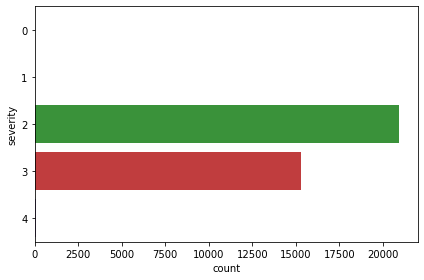

In [9]:
#characterstick graph
#severity vs count

sns.countplot(y = "severity" , data = df )
plt.tight_layout()

In [10]:
#here we check for outlier and boundries

pd.DataFrame( {"count": df["severity"].value_counts().values } , index = df["severity"].value_counts().index )

,count
2,20944
3,15296
4,54
1,19
0,1


**The dataset is very unbalanced so we remove the rows with severity = 0 , 1 or 4**

In [11]:
df = df.loc[df["severity"] >  1].loc[df["severity"] < 4]


**Pre-Processing the time features: creating months, weekday year and hour features because we cant use time directly , its in DD:MM:YY HH:MM:SS format**

In [12]:
df["month"] = df["time"].apply(lambda x:int(x[:2]))
df["day"] = df["time"].apply(lambda x:int(x[3:5]))
df["year"] = df["time"].apply(lambda x:int(x[6:8]))
df["hour"] =  df["time"].apply(lambda x: int(x[9:11]) if str(x)[15] == 'A' else 12 + int(x[9:11])  )
df["lon"] = df["lon"].apply(lambda x:abs(x)) #so that multinomialNB works (only with positive features)
#creating the date at the datetime format (easier to deal with)
df[ "date" ]= df[["month" , "day" ,"year"]].apply(lambda x:pd.datetime(month = x['month'] , day = x['day']  , year = 2000+x["year"]), axis = 1)
df["weekday"] =  df["date"].apply(lambda x:x.weekday())

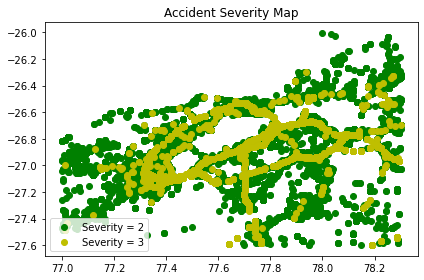

In [13]:
#plotting the dataset with a different color depending on the severity (2,3)
#longitude vs lattitude

df2 = df.loc[df["severity"] == 2]
df3 = df.loc[df["severity"] == 3]

xx2 , yy2 = df2["lat"] , -df2["lon"]
xx3 , yy3 = df3["lat"] , -df3["lon"]

pts2 = plt.scatter(xx2,yy2,color = 'g' )
pts3 = plt.scatter(xx3,yy3,color = 'y' )
plt.legend((pts2, pts3), ('Severity = 2', 'Severity = 3'),loc='lower left')
plt.title("Accident Severity Map")
plt.tight_layout()

**Univariate and different Analysis wrt differnt variables in the data sets are as follow :-**

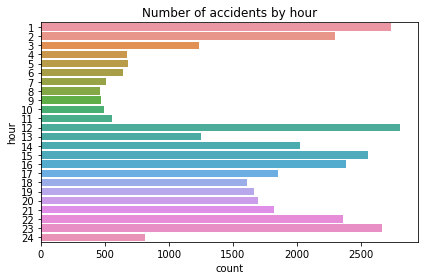

In [14]:
#classifiction , hour vs counts

sns.countplot(y = "hour" , data = df , order = range(1,25))
plt.title("Number of accidents by hour")
plt.tight_layout()

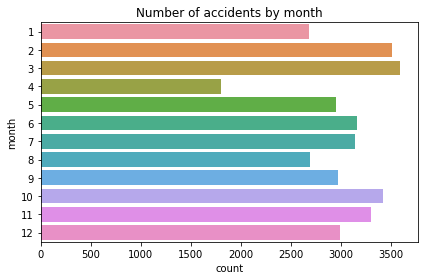

In [15]:
#classification , month vs count

sns.countplot(y = "month" , data = df)
plt.title("Number of accidents by month")
plt.tight_layout()

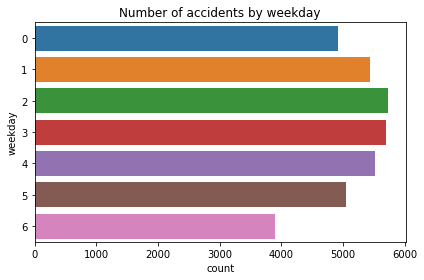

In [16]:
#classification , weekdays vs count

sns.countplot(y = "weekday" , data = df)
plt.title("Number of accidents by weekday")
plt.tight_layout()

In [17]:
#ratio of severity ( 0 and 1 ) wrt time( hour)
#here we find out that , why we need to 
#the outliers , additional information 
#this tells us the severity of accidents wrt time and when most of the accidents happens 
#and with what severity

severity_by_hour = pd.crosstab(index = df["hour"] , columns = df["severity"] )
severity_by_hour = pd.DataFrame(severity_by_hour.values)
severity_by_hour["ratio"] = severity_by_hour.apply(lambda x:x[0]/float(x[1]) , axis = 1)
severity_by_hour.sort_values(by = "ratio")

,0,1,ratio
22,1363,1301,1.047656
0,1402,1329,1.054929
11,1447,1355,1.067897
12,656,596,1.100671
21,1300,1061,1.225259
23,452,358,1.262570
1,1283,1015,1.264039
13,1132,892,1.269058
20,1040,778,1.336761
14,1494,1060,1.409434


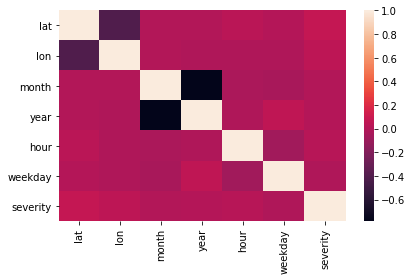

In [18]:
#correlation heatmap
df_corr = df[["lat" , "lon" , "month" , "year" , "hour" , "weekday" , "severity"]]
correlation = df_corr.corr()
sns.heatmap(correlation)
plt.tight_layout()

**Machine Learning and Different Algorithm's to predict Accidents Severity**
> Here we will create training and test sets to use with cross valiadion
> Also we are splitting the test size as 0.2 ( so its 20 % : test and 80 % : train) 

In [19]:
X = df[["month" , "hour" , "year", "weekday" ,"lon" , "lat"]]
y = df["severity"].apply(lambda x:x-2) # shifting to 0-1 values instead of 2-3

Spliting Data into Train Test split

In [21]:
#here we assign test size as 20% of actual data set 
# random state is set as 42 ( or 1 ) also from the reference of " The Hitchhiker's Guide to the Galaxy" 
# we defined random state to get consistent and same results , regardless of the training iterations 
# so that the values in the train and test sets are homogenous

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [22]:
#using the metrics package
#algorithm's func to print the results
from sklearn.metrics import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
def printScores(y_test, y_pred, classif_name):    
    print ("--------------  "  + classif_name + "  ------------------")
    print ("recall : %0.2f" %  recall_score(y_test, y_pred) )
    print ("precision : %0.2f" %  precision_score(y_test, y_pred))   
    print ("f1 : %0.2f" %  f1_score(y_test, y_pred))
    print ("accuracy : %0.2f" %  accuracy_score(y_test, y_pred))
    print ("---------------------------------------------------")

Before using sophisticated and predefined models, let's see what results the worst classifier would give

In [23]:
#basic model to check accurary (worst)

sev = y.value_counts()
pd.DataFrame(sev)

,severity
0,20944
1,15296


In [25]:
#here we will calculate the worst accuracy 

print ("worst accuracy is : " , max(sev)/float(sum(sev)))

worst accuracy is :  0.577924944812362


**below are some algoriths which we tested (differnet approaches)
and we will chose the one with max accuracy and suitable for our model **

In [26]:
# knn 

# the distance func is being used here and the previous prediction 
# by KNN is being used , i.e 1, 3 ,7 
# here it also non parametrized

from sklearn.neighbors import KNeighborsClassifier
for nb in [1,3,7]:
    print ("nb neighbors: %d" %nb)    
    clf = KNeighborsClassifier(n_neighbors=nb)
    clf.fit(X_train,y_train)
    y_pred = pd.Series(clf.predict(X_test))
    printScores(y_test, y_pred, "KNeighborsClassifier")

nb neighbors: 1
--------------  KNeighborsClassifier  ------------------
recall : 0.66
precision : 0.61
f1 : 0.63
accuracy : 0.68
---------------------------------------------------
nb neighbors: 3
--------------  KNeighborsClassifier  ------------------
recall : 0.61
precision : 0.56
f1 : 0.58
accuracy : 0.63
---------------------------------------------------
nb neighbors: 7
--------------  KNeighborsClassifier  ------------------
recall : 0.55
precision : 0.52
f1 : 0.53
accuracy : 0.59
---------------------------------------------------


In [27]:
#logreg (it predicts everything to 0, the most common class)
# a predictive analysis , where we comapre a relation between binary varaible 
# and other ordinal and nominal and indepdendent variables
#also here we are not using any paramneter's
#use from training set and test sets 
#for cross valiadtion


from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train,y_train)
y_pred = pd.Series(clf.predict(X_test))
printScores(y_test, y_pred, "LogisticRegression")

--------------  LogisticRegression  ------------------
recall : 0.00
precision : 0.00
f1 : 0.00
accuracy : 0.58
---------------------------------------------------


In [28]:
#tree

#structured tree where it containts root nodes , leaf node
#each brach of the tre depicts outcome of the tree

# use from training set and test sets 
#for cross valiadtion

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
printScores(y_test, y_pred, "tree")

--------------  tree  ------------------
recall : 0.92
precision : 0.90
f1 : 0.91
accuracy : 0.93
---------------------------------------------------


What are the most important features?

In [29]:
pd.DataFrame(100*clf.feature_importances_ , index = X_train.columns)

,0
month,3.524127
hour,5.008499
year,0.209836
weekday,3.233219
lon,44.623763
lat,43.400555


The position features (lat and lon) are undoubtedly the most important.
> On the other hand year doesn't provide much information.
> now taking the lat and lon as the primary source in the new training set
> we reapply the algorithm , because other values seems to less effecting
> Results are better when we only keep 2 predictors: "lat" and "lon". 

In [30]:
#MODIFIED TRAINING SET of lat and longitude
#this one is parametrized
# use from training set and test sets , only 2 variables , lat and lon
#for cross validation

X_train2 , X_test2 = X_train[["lat" , "lon" ]]  , X_test[["lat" , "lon" ]]


In [31]:
#SVM
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train2, y_train)  
y_pred = clf.predict(X_test2)
printScores(y_test, y_pred, "svm")

--------------  svm  ------------------
recall : 0.00
precision : 0.00
f1 : 0.00
accuracy : 0.58
---------------------------------------------------


In [32]:
#tree


from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train2,y_train)
y_pred = clf.predict(X_test2)
printScores(y_test, y_pred, "tree")

--------------  tree  ------------------
recall : 0.96
precision : 0.93
f1 : 0.94
accuracy : 0.95
---------------------------------------------------


In [33]:
#random forest

# use from training set and test sets 
# for cross valiadtion
#n_estiamotor is 100 , as default from update of 2.10

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100)
clf.fit(X_train2,y_train)
y_pred = clf.predict(X_test2)
printScores(y_test, y_pred, "RandomForestClassifier")

--------------  RandomForestClassifier  ------------------
recall : 0.96
precision : 0.93
f1 : 0.94
accuracy : 0.95
---------------------------------------------------


In [34]:
#logreg 

# use from training set and test sets 
#for cross valiadtion

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train2,y_train)
y_pred = pd.Series(clf.predict(X_test2))
printScores(y_test, y_pred, "LogisticRegression")

--------------  LogisticRegression  ------------------
recall : 0.09
precision : 0.31
f1 : 0.14
accuracy : 0.53
---------------------------------------------------


> The tree based model (decision tree and random forest) perform the best
> How big should be our training set?
> Is collecting more data worth it? And will it improve our model?

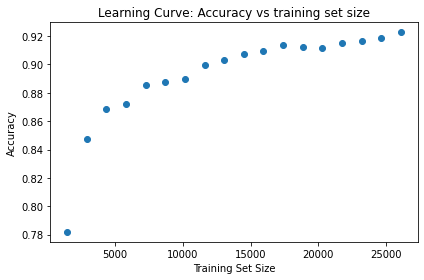

In [36]:
#drawing the prediction graph

training_set_size = [0.05*i for i in range(1,19)]
accuracy = []
from sklearn import tree   
for size in training_set_size:
    # won't be using the test in that case...this is just a way of splitting the data
    X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train, test_size=1-size, random_state=42) 
    clf = tree.DecisionTreeClassifier()  
    clf.fit(X_train2,y_train2)
    y_pred = clf.predict(X_test)
    #printScores(y_test, y_pred, "tree")
    accuracy.append(  (X_train2.shape[0] ,accuracy_score(y_test, y_pred) )  )

xx = [w[0] for w in accuracy]
yy = [w[1] for w in accuracy]
plt.scatter(xx,yy)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title("Learning Curve: Accuracy vs training set size")
plt.tight_layout()